In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
mimic = pd.read_csv('/mnt/d/data/mimic-iv-note-deidentified-free-text-clinical-notes-2.2/mimic-iv-note-deidentified-free-text-clinical-notes-2.2/note/radiology.csv')

In [3]:
mimic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321355 entries, 0 to 2321354
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   note_id     object 
 1   subject_id  int64  
 2   hadm_id     float64
 3   note_type   object 
 4   note_seq    int64  
 5   charttime   object 
 6   storetime   object 
 7   text        object 
dtypes: float64(1), int64(2), object(5)
memory usage: 141.7+ MB


In [4]:
mimic_cancer = mimic[mimic.text.str.lower().str.contains('cancer|restaging|malignan')] 
mimic_cancer = mimic_cancer[mimic_cancer.text.str.lower().str.contains('ct |mr |pet |nm |mammo')]

In [5]:
mimic_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217642 entries, 9 to 2321304
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   note_id     217642 non-null  object 
 1   subject_id  217642 non-null  int64  
 2   hadm_id     55804 non-null   float64
 3   note_type   217642 non-null  object 
 4   note_seq    217642 non-null  int64  
 5   charttime   217642 non-null  object 
 6   storetime   217642 non-null  object 
 7   text        217642 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 14.9+ MB


In [8]:
mimic_cancer['text'] = mimic_cancer['text'].str.lower().str.replace("\n", " ")

In [9]:
phi_data = pd.read_csv('/mnt/d/Dropbox (Partners HealthCare)/profile_3-2023/derived_data/labeled_imaging_prissmm.csv')

# define mixed response to be progression
phi_data['text'] = phi_data.text.str.lower().str.replace("\n", " ")
phi_data['progression'] = np.where(phi_data.class_status==3, 1, phi_data.progression)

#phi_data.class_status.value_counts()

In [ ]:
validation = phi_data[phi_data.split=='validation']

#validation.head()
#validation['length'] = validation.text.str.count(' ')

In [ ]:
test = phi_data[phi_data.split=='test']

#test.head()

In [11]:
from torch.utils import data

class UnLabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)


        return x_text_tensor, x_attention_mask
        

In [13]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self):
        super(LabeledModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.brain_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.bone_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.adrenal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.liver_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.lung_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.node_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.peritoneal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))

        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        
        main = self.bert(x_text_tensor, x_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)
        brain_out = self.brain_head(main)
        bone_out = self.bone_head(main)
        adrenal_out = self.adrenal_head(main)
        liver_out = self.liver_head(main)
        lung_out = self.lung_head(main)
        node_out = self.node_head(main)
        peritoneum_out = self.peritoneal_head(main)


        
        return any_cancer_out, response_out, progression_out, brain_out, bone_out, adrenal_out, liver_out, lung_out, node_out, peritoneum_out
        




In [17]:
# run inference using the PHI-trained model on the synthetic immpressions

themodel = LabeledModel()
themodel.load_state_dict(torch.load('./pan_prissmm_full_imaging_bert.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(UnLabeledDataset(mimic_cancer), batch_size=16, shuffle=False, num_workers=0)

output_prediction_lists = [[] for x in range(10)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(10):
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_synthetic = mimic_cancer.copy()
for x in range(10):
    output_synthetic['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]




                              

In [19]:
output_synthetic.to_csv('./data/mimic_pseudolabeleld.csv')

In [22]:
from torch.utils import data

class PseudoLabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        #y_class_status = torch.tensor(pand.class_status, dtype=torch.long)

        outcome_vars = [pand['outcome_' + str(x) + '_logit'] for x in range(10)]
        return x_text_tensor, x_attention_mask, *tuple(outcome_vars)
        
        

In [17]:
from torch.utils import data

class LabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
        #label = torch.tensor(pand.progression, dtype=torch.float32)
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        y_any_cancer = torch.tensor(pand.any_cancer, dtype=torch.float32)
        y_response = torch.tensor(pand.response, dtype=torch.float32)
        y_progression = torch.tensor(pand.progression, dtype=torch.float32)
        
        y_brain_met = torch.tensor(pand.brain_met, dtype=torch.float32)
        y_bone_met = torch.tensor(pand.bone_met, dtype=torch.float32)
        y_adrenal_met = torch.tensor(pand.adrenal_met, dtype=torch.float32)
        y_liver_met = torch.tensor(pand.liver_met, dtype=torch.float32)
        y_lung_met = torch.tensor(pand.lung_met, dtype=torch.float32)
        y_node_met = torch.tensor(pand.node_met,  dtype=torch.float32)
        y_peritoneal_met = torch.tensor(pand.peritoneal_met, dtype=torch.float32)

        return x_text_tensor, x_attention_mask, y_any_cancer, y_response, y_progression, y_brain_met, y_bone_met, y_adrenal_met, y_liver_met, y_lung_met, y_node_met, y_peritoneal_met
        
        

In [15]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self):
        super(LabeledModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.brain_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.bone_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.adrenal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.liver_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.lung_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.node_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.peritoneal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))

        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        
        main = self.bert(x_text_tensor, x_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)
        brain_out = self.brain_head(main)
        bone_out = self.bone_head(main)
        adrenal_out = self.adrenal_head(main)
        liver_out = self.liver_head(main)
        lung_out = self.lung_head(main)
        node_out = self.node_head(main)
        peritoneum_out = self.peritoneal_head(main)


        
        return any_cancer_out, response_out, progression_out, brain_out, bone_out, adrenal_out, liver_out, lung_out, node_out, peritoneum_out
        




In [27]:
# train loop
from transformers import get_scheduler
from torch.optim import AdamW, Adam


def train_model(model, num_epochs, trainloader, validloader=None, device='cuda'):
    
    

    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = num_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_losses = [0.0 for i in range(10)]
        mean_train_losses = [0.0 for i in range(10)]
        
        running_valid_losses = [0.0 for i in range(10)]
        mean_valid_losses = [0.0 for i in range(10)]

        num_train_batches = len(trainloader)
                
        model.train()
        
        for i, batch in enumerate(trainloader, 0):
            input_ids = batch[0].to(device)
            input_masks = batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs_true = [x.to(device) for x in batch[2:]]
            
            outputs_pred = model(input_ids, input_masks)
            
           
            losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), torch.sigmoid(outputs_true[x])) for x in range(10)]
            
            total_loss = 0.0
            for j in range(10):
                total_loss = total_loss + losses[j]

                
            total_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            
            for j in range(10):
                running_train_losses[j] += losses[j].detach().cpu().numpy()
                mean_train_losses[j] = running_train_losses[j] / (i+1)
                
            print('Training Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ' this_loss:' + str(total_loss.detach().cpu().numpy()) +', train losses: ' + str([str(x) + ': ' + str(mean_train_losses[x]) + ", " for x in range(10)]), end='\r', flush=True)
        
        print('\n')
        # eval on valid
        
        if validloader is not None:
            num_valid_batches = len(validloader)
            model.eval()
            
            for i, batch in enumerate(validloader, 0):
                input_ids = batch[0].to(device)
                input_masks = batch[1].to(device)


                outputs_true = [x.to(device) for x in batch[2:]]

                outputs_pred = model(input_ids, input_masks)

                losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), torch.sigmoid(outputs_true[x])) for x in range(10)]

                total_loss = 0.0
                for j in range(10):
                    total_loss = total_loss + losses[j]
                


                for j in range(10):
                    running_valid_losses[j] += losses[j].detach().cpu().numpy()

            
            for j in range(10):
                mean_valid_losses[j] = running_valid_losses[j] / (i+1)
            

            
            print('Validation Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_valid_batches) + ', valid losses: ' + str([str(x) + ': ' + str(mean_valid_losses[x]) + ", " for x in range(10)]), end='\r', flush=True)
            print('\n')

    

In [28]:
# actual student model training, commented out after model trained.

# themodel = LabeledModel().to('cuda')
# trainloader = data.DataLoader(PseudoLabeledDataset(output_synthetic.reset_index(drop=True)), batch_size=16, num_workers=8, shuffle=True)
# validloader = data.DataLoader(LabeledDataset(validation.reset_index(drop=True)), batch_size=16, num_workers=8, shuffle=True)
# train_model(themodel,3, trainloader, validloader)

Training Epoch: 1, batch: 13603/13603 this_loss:0.3519427, train losses: ['0: 0.1779681941721511, ', '1: 0.04469829558711224, ', '2: 0.1289762667856307, ', '3: 0.024893442760621835, ', '4: 0.04887782522866567, ', '5: 0.019491172020170144, ', '6: 0.046117506188327544, ', '7: 0.09407626781686576, ', '8: 0.07966019689087787, ', '9: 0.02403368236541067, ']']]]]]

Validation Epoch: 1, batch: 218/218, valid losses: ['0: 1.5361716102022644, ', '1: 2.7714837789535522, ', '2: 1.982736510421158, ', '3: 3.2235234636779224, ', '4: 2.7204167941294677, ', '5: 3.485841561894898, ', '6: 2.85972636227214, ', '7: 2.514747526667534, ', '8: 2.6511189959464816, ', '9: 3.363218861982363, ']

Training Epoch: 2, batch: 13603/13603 this_loss:0.45713416, train losses: ['0: 0.1448737807027732, ', '1: 0.03529373886928949, ', '2: 0.1104413632803678, ', '3: 0.01800680306134468, ', '4: 0.034860888573611575, ', '5: 0.013368428203572612, ', '6: 0.032717436605013576, ', '7: 0.07537787613057524, ', '8: 0.064439560571718

In [29]:
#torch.save(themodel.state_dict(), 'dfci_mimic_imaging_bert.pt')

In [30]:
# write out actual validation dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_mimic_imaging_bert.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(validation), batch_size=16, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(10)]
output_prediction_lists = [[] for x in range(10)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(10):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_validation = validation.copy()
for x in range(10):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



In [32]:
from sklearn.metrics import roc_auc_score


In [33]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(10)]

0.9643401154925542
0.9679234194891039
0.9579313255464614
0.9880559864027715
0.9871993140205286
0.9810639229422067
0.9847930920829643
0.9664660350005178
0.9741968254385734
0.9868170755814518


[None, None, None, None, None, None, None, None, None, None]

In [36]:
from utils_102023 import *

AUC 0.9643401154925542
Outcome probability: 0.5353245261344055
Average precision score: 0.97
Best F1: 0.9075235109717869


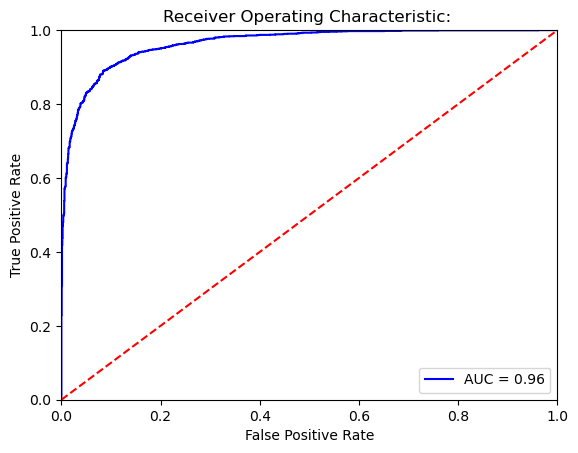

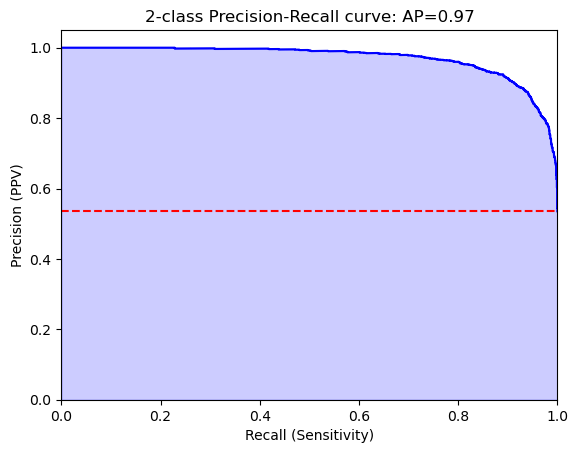

Threshold for best F1:
-0.3404698
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1391  227]
 [ 127 1737]]


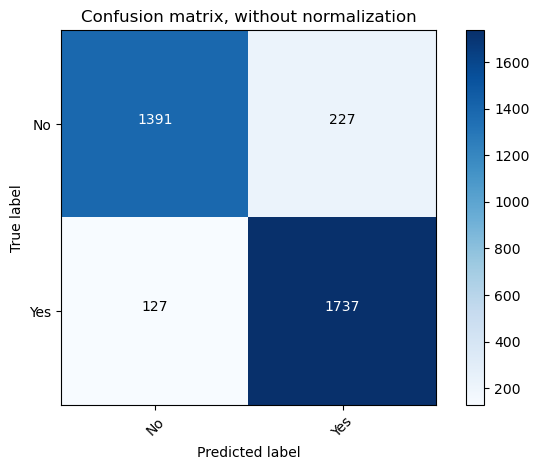

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.86      0.89      1618
         Yes       0.88      0.93      0.91      1864

    accuracy                           0.90      3482
   macro avg       0.90      0.90      0.90      3482
weighted avg       0.90      0.90      0.90      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1463  155]
 [ 192 1672]]


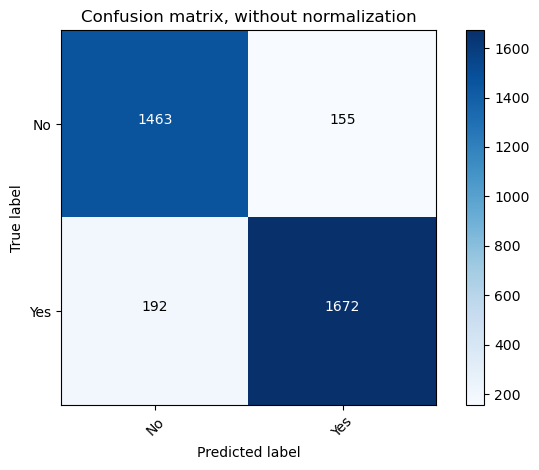

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.88      0.90      0.89      1618
         Yes       0.92      0.90      0.91      1864

    accuracy                           0.90      3482
   macro avg       0.90      0.90      0.90      3482
weighted avg       0.90      0.90      0.90      3482



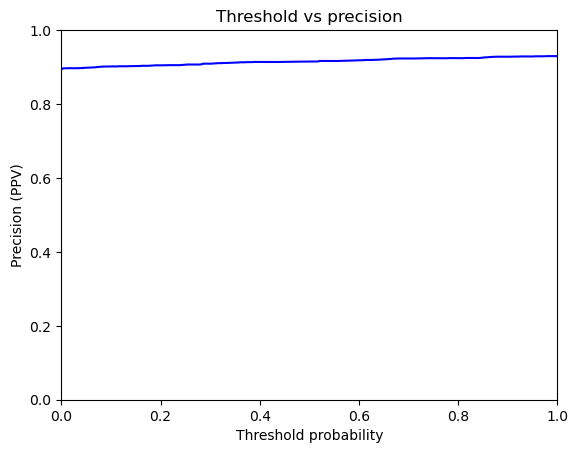

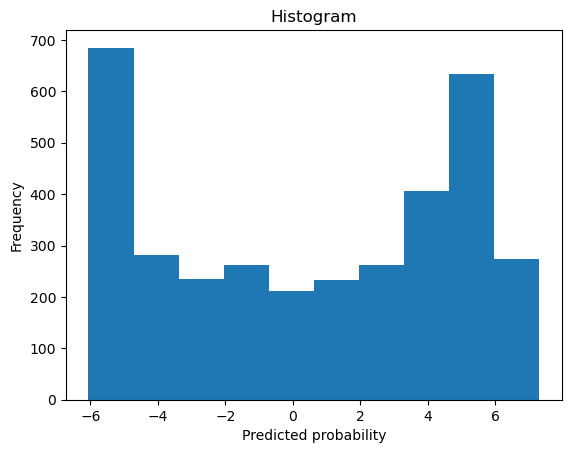

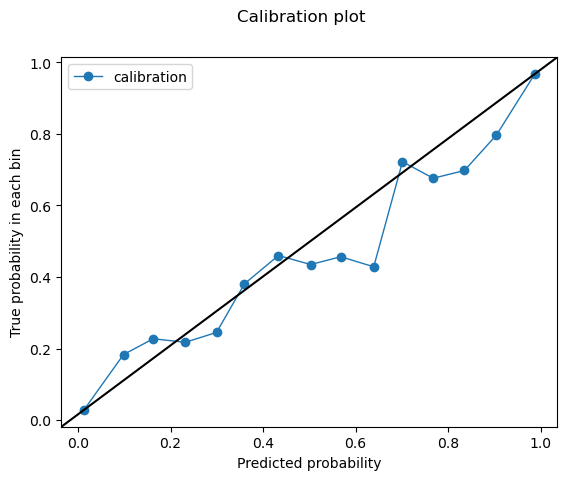

-0.3404698

In [37]:
eval_model(output_prediction_lists[0], output_true_lists[0], graph=True)

AUC 0.9679234194891039
Outcome probability: 0.06547960941987363
Average precision score: 0.76
Best F1: 0.7167381974248926


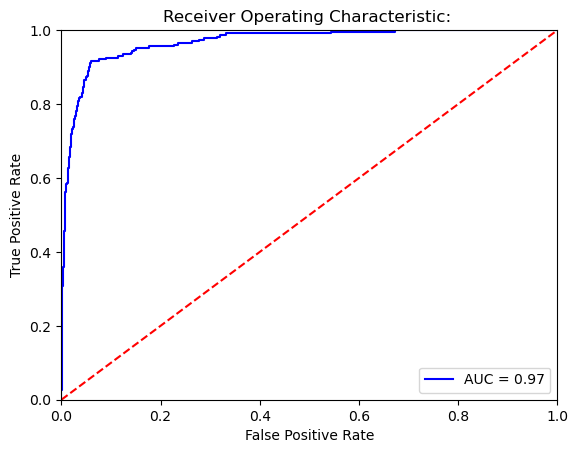

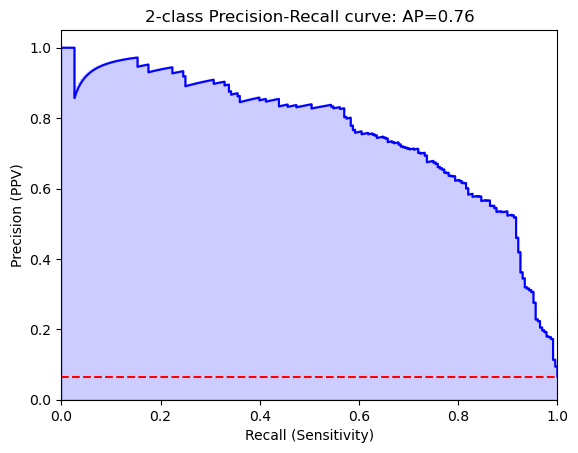

Threshold for best F1:
-0.32101443
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3183   71]
 [  61  167]]


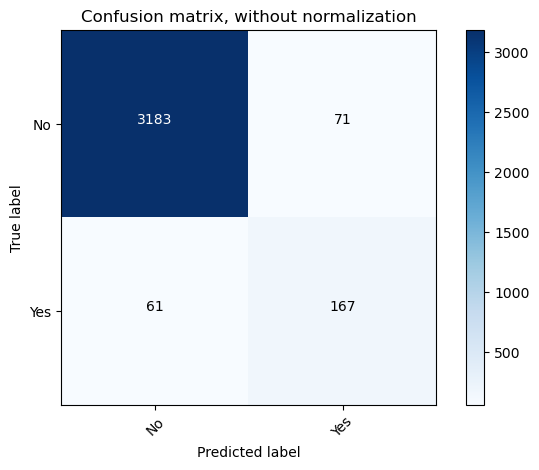

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.98      0.98      3254
         Yes       0.70      0.73      0.72       228

    accuracy                           0.96      3482
   macro avg       0.84      0.86      0.85      3482
weighted avg       0.96      0.96      0.96      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3202   52]
 [  79  149]]


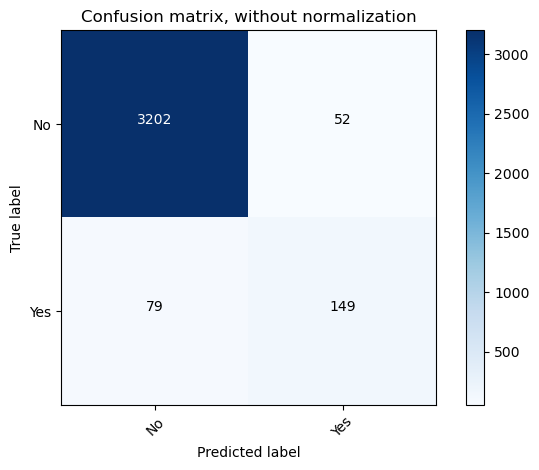

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.98      0.98      3254
         Yes       0.74      0.65      0.69       228

    accuracy                           0.96      3482
   macro avg       0.86      0.82      0.84      3482
weighted avg       0.96      0.96      0.96      3482



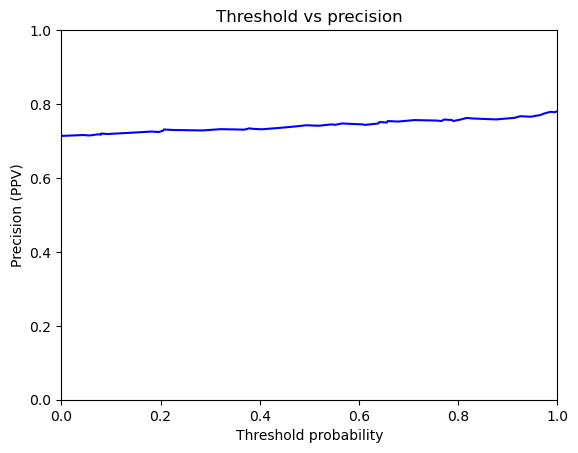

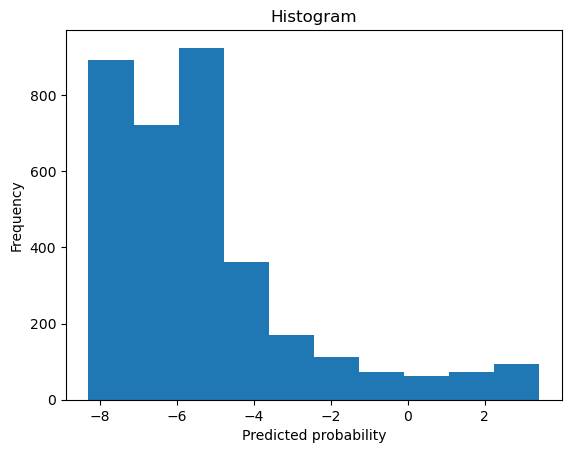

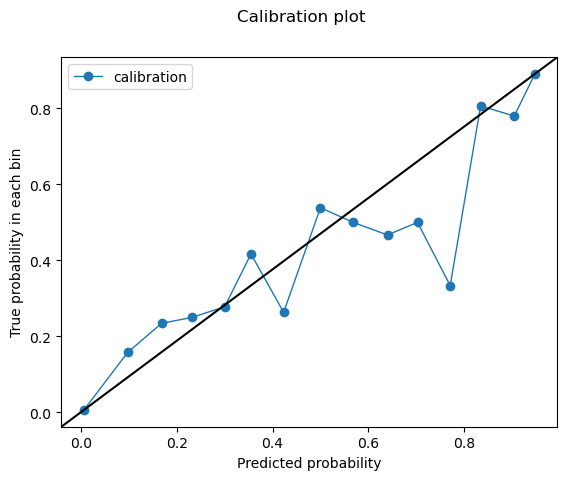

-0.32101443

In [38]:
eval_model(output_prediction_lists[1], output_true_lists[1], graph=True)

AUC 0.9579313255464614
Outcome probability: 0.25100516944284895
Average precision score: 0.89
Best F1: 0.8148578061520603


/mnt/d/Dropbox (Partners HealthCare)/impression_bert/prissmm_imaging/utils_102023.py:111: RuntimeWarning: invalid value encountered in divide
  F1 = 2*((precision*recall)/(precision+recall))


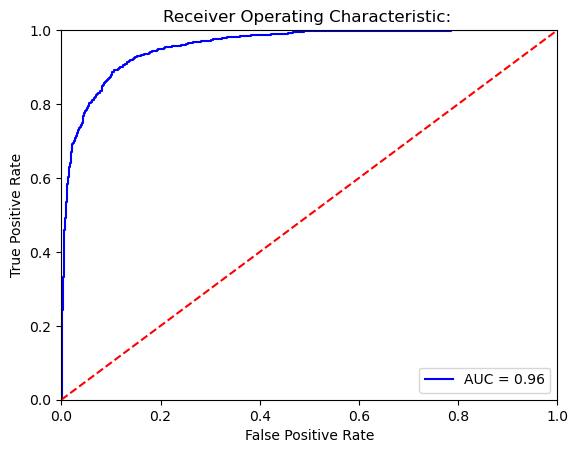

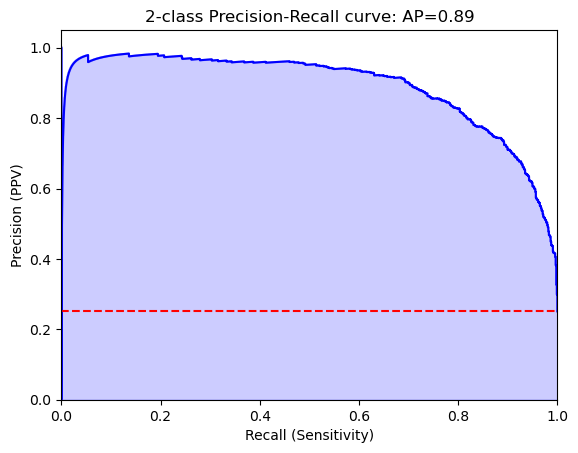

Threshold for best F1:
5.238657
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2607    1]
 [ 874    0]]


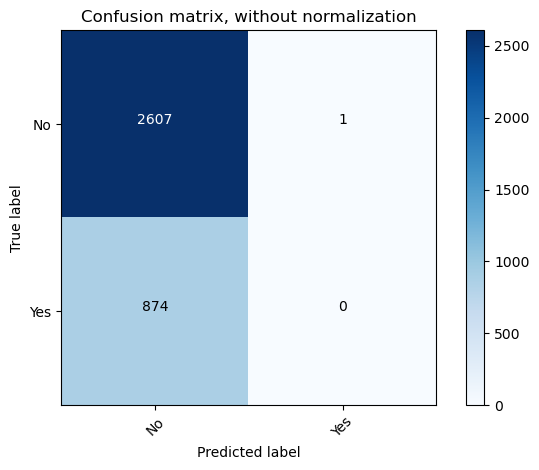

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.75      1.00      0.86      2608
         Yes       0.00      0.00      0.00       874

    accuracy                           0.75      3482
   macro avg       0.37      0.50      0.43      3482
weighted avg       0.56      0.75      0.64      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2510   98]
 [ 229  645]]


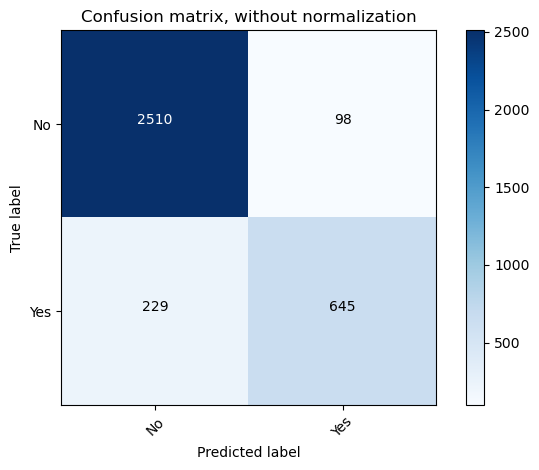

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.96      0.94      2608
         Yes       0.87      0.74      0.80       874

    accuracy                           0.91      3482
   macro avg       0.89      0.85      0.87      3482
weighted avg       0.90      0.91      0.90      3482



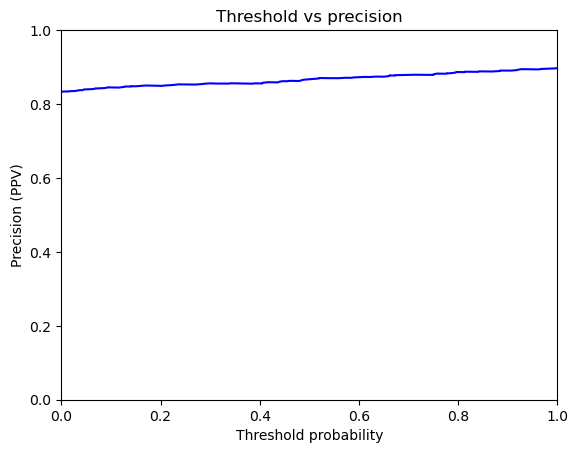

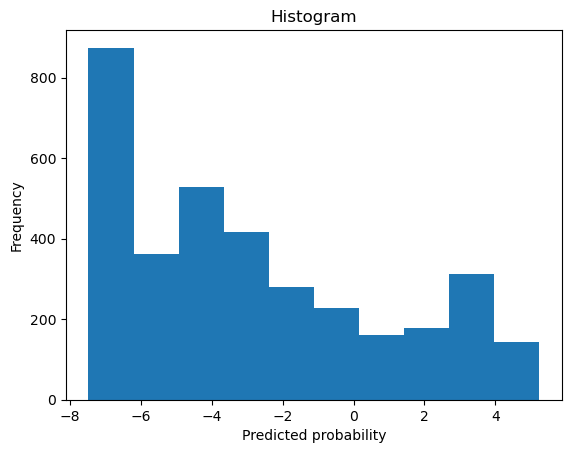

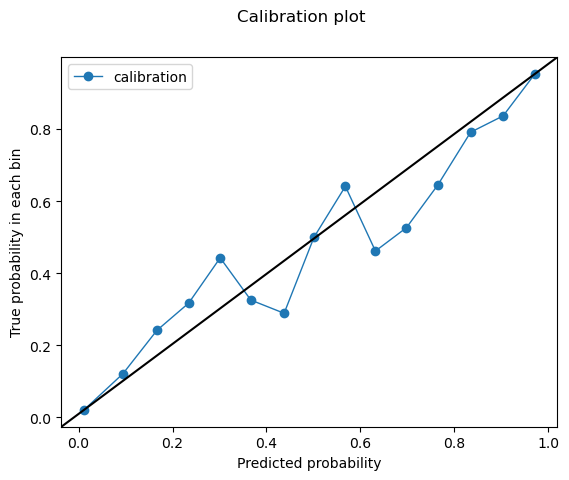

5.238657

In [39]:
eval_model(output_prediction_lists[2], output_true_lists[2], graph=True)

AUC 0.9880559864027715
Outcome probability: 0.07696726019529006
Average precision score: 0.92
Best F1: 0.8571428571428571


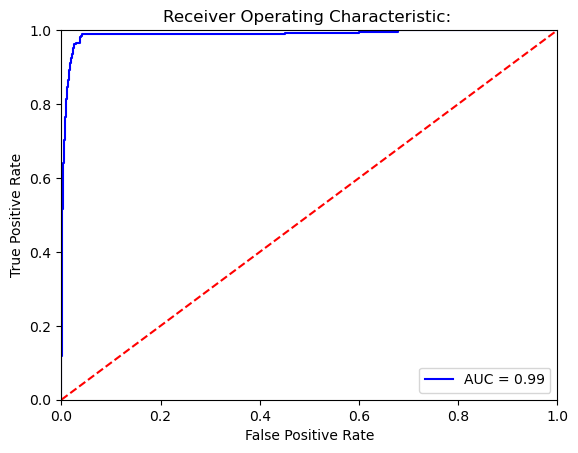

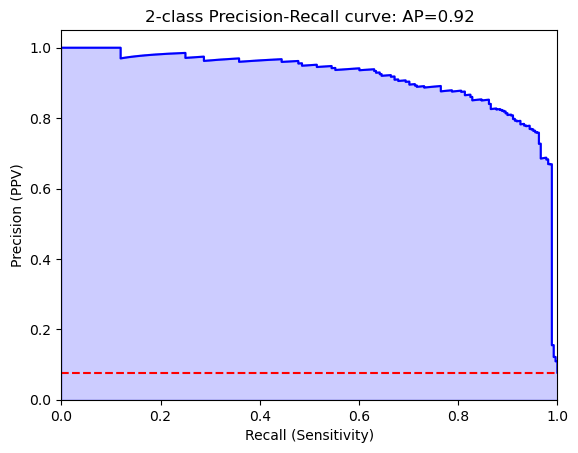

Threshold for best F1:
0.83631194
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3174   40]
 [  37  231]]


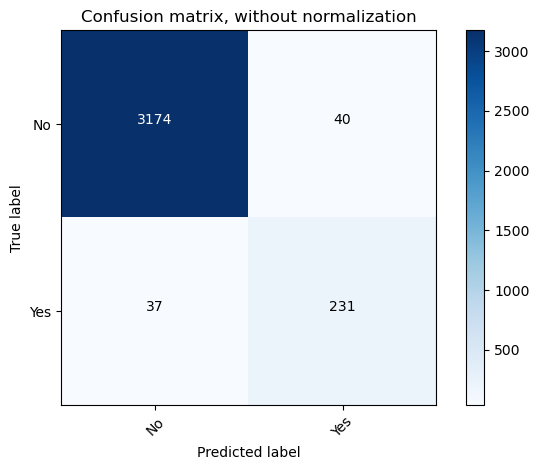

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.99      0.99      3214
         Yes       0.85      0.86      0.86       268

    accuracy                           0.98      3482
   macro avg       0.92      0.92      0.92      3482
weighted avg       0.98      0.98      0.98      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3165   49]
 [  33  235]]


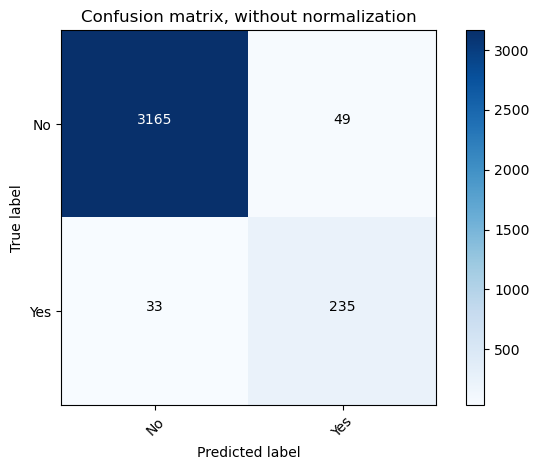

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.98      0.99      3214
         Yes       0.83      0.88      0.85       268

    accuracy                           0.98      3482
   macro avg       0.91      0.93      0.92      3482
weighted avg       0.98      0.98      0.98      3482



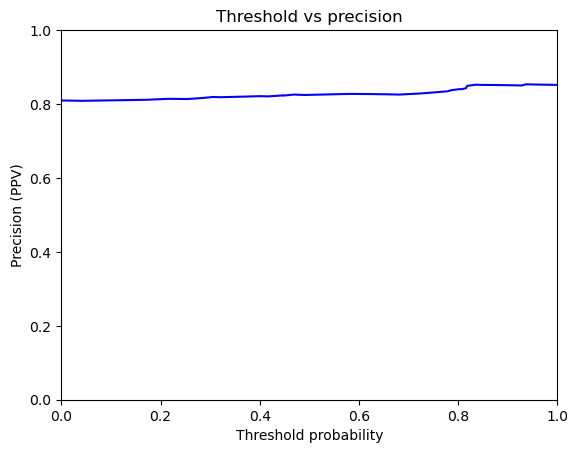

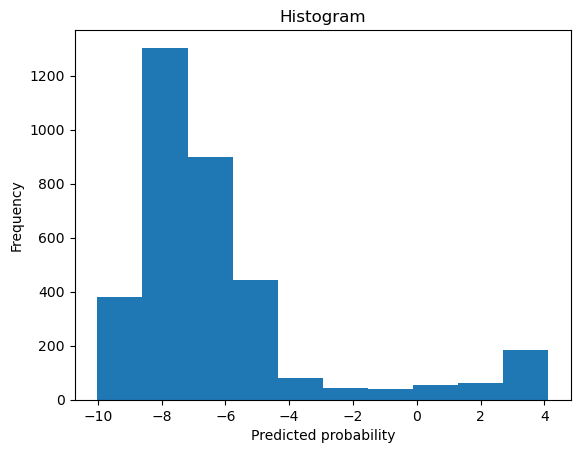

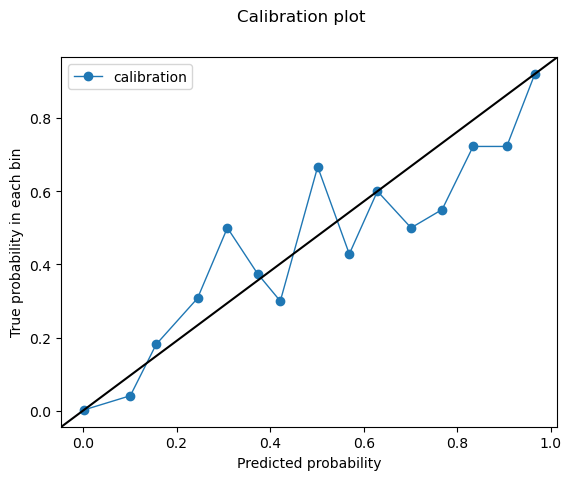

0.83631194

In [40]:
eval_model(output_prediction_lists[3], output_true_lists[3], graph=True)

AUC 0.9871993140205286
Outcome probability: 0.15393452039058012
Average precision score: 0.95
Best F1: 0.9037735849056604


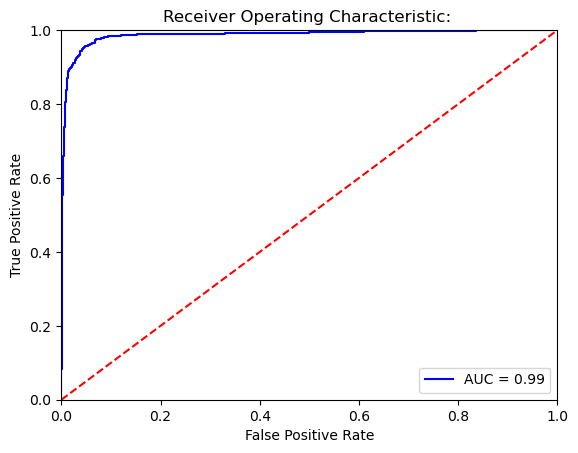

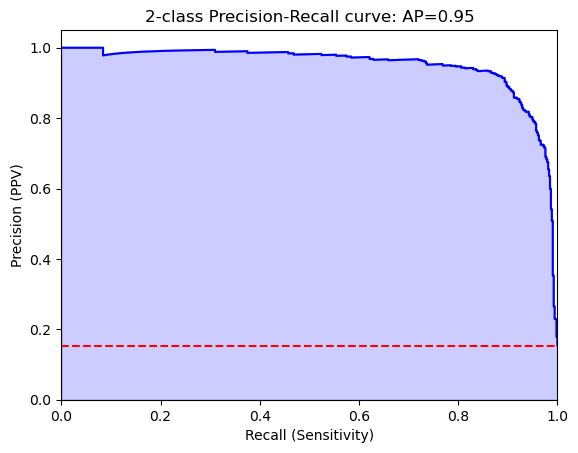

Threshold for best F1:
0.3463397
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2901   45]
 [  57  479]]


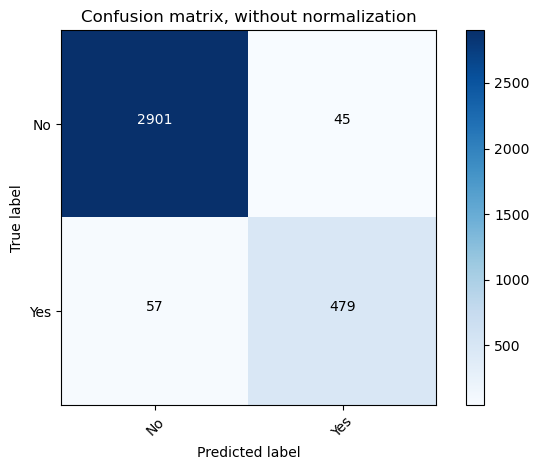

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.98      0.98      2946
         Yes       0.91      0.89      0.90       536

    accuracy                           0.97      3482
   macro avg       0.95      0.94      0.94      3482
weighted avg       0.97      0.97      0.97      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2904   42]
 [  61  475]]


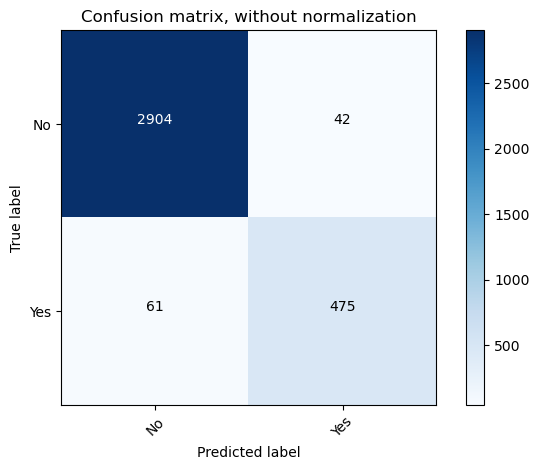

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.99      0.98      2946
         Yes       0.92      0.89      0.90       536

    accuracy                           0.97      3482
   macro avg       0.95      0.94      0.94      3482
weighted avg       0.97      0.97      0.97      3482



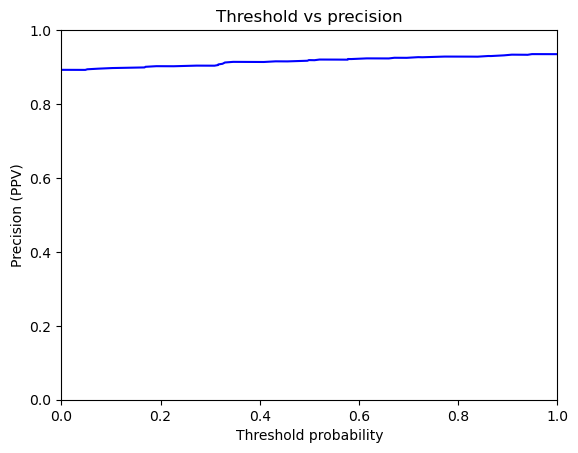

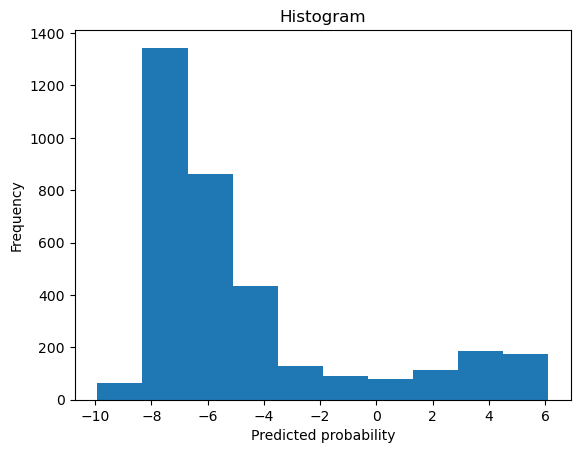

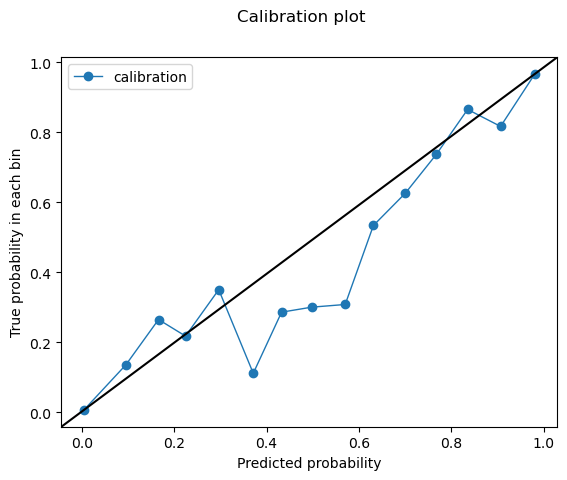

0.3463397

In [41]:
eval_model(output_prediction_lists[4], output_true_lists[4], graph=True)

AUC 0.9810639229422067
Outcome probability: 0.016082711085583
Average precision score: 0.76
Best F1: 0.7333333333333334


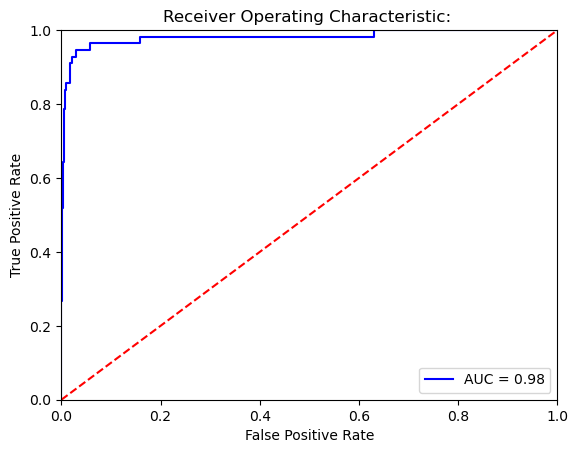

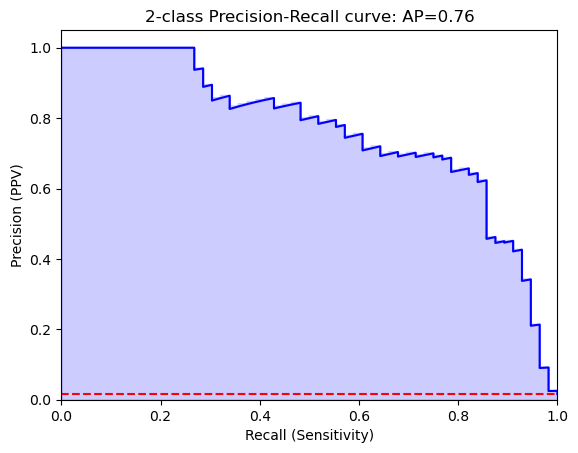

Threshold for best F1:
-0.7967122
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3406   20]
 [  12   44]]


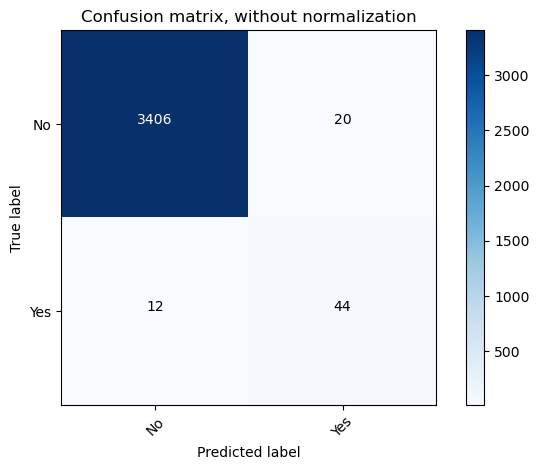

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       1.00      0.99      1.00      3426
         Yes       0.69      0.79      0.73        56

    accuracy                           0.99      3482
   macro avg       0.84      0.89      0.86      3482
weighted avg       0.99      0.99      0.99      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3415   11]
 [  23   33]]


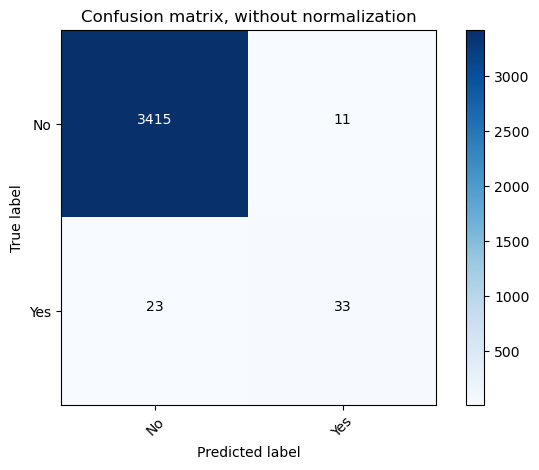

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      1.00      1.00      3426
         Yes       0.75      0.59      0.66        56

    accuracy                           0.99      3482
   macro avg       0.87      0.79      0.83      3482
weighted avg       0.99      0.99      0.99      3482



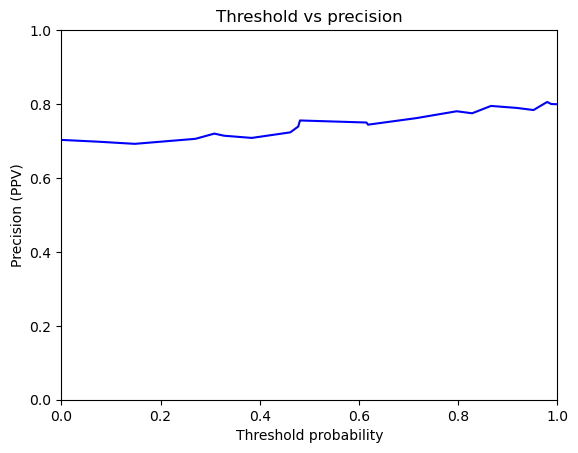

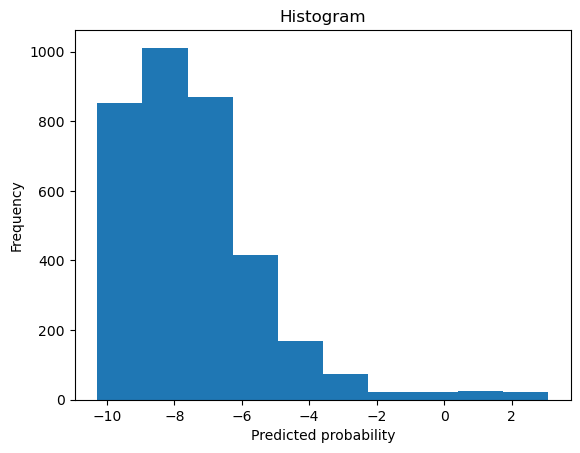

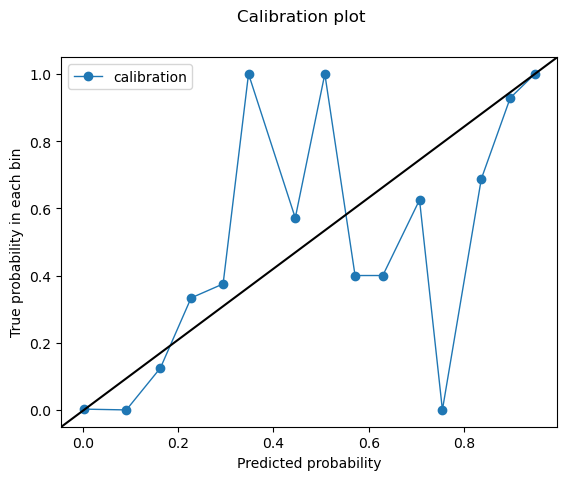

-0.7967122

In [42]:
eval_model(output_prediction_lists[5], output_true_lists[5], graph=True)

AUC 0.9847930920829643
Outcome probability: 0.12033314187248707
Average precision score: 0.91
Best F1: 0.8666666666666668


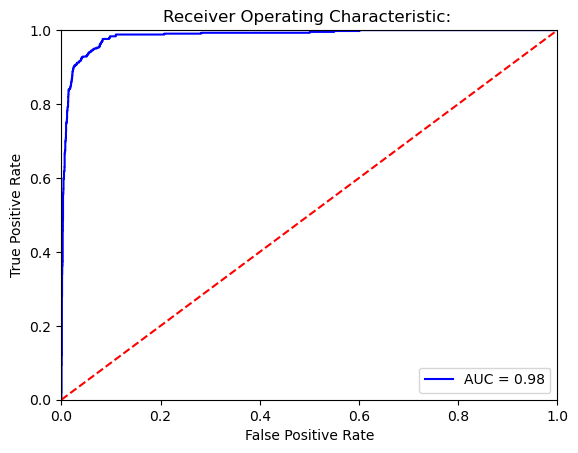

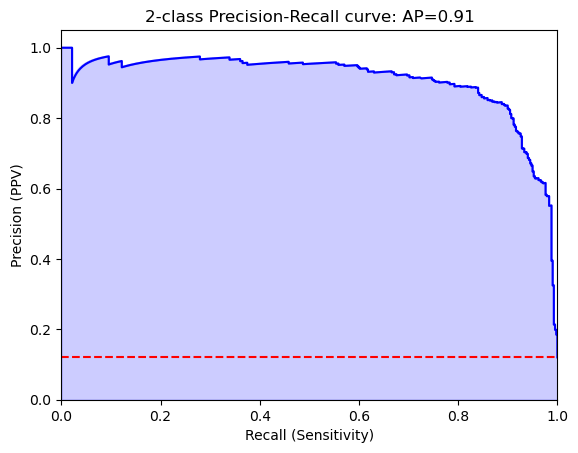

Threshold for best F1:
-0.5125628
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2989   74]
 [  42  377]]


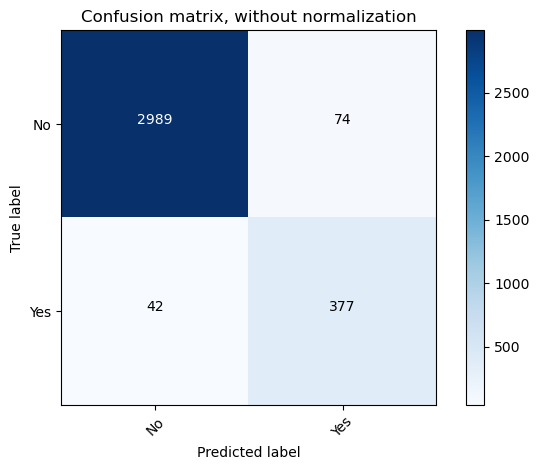

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.98      0.98      3063
         Yes       0.84      0.90      0.87       419

    accuracy                           0.97      3482
   macro avg       0.91      0.94      0.92      3482
weighted avg       0.97      0.97      0.97      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3019   44]
 [  70  349]]


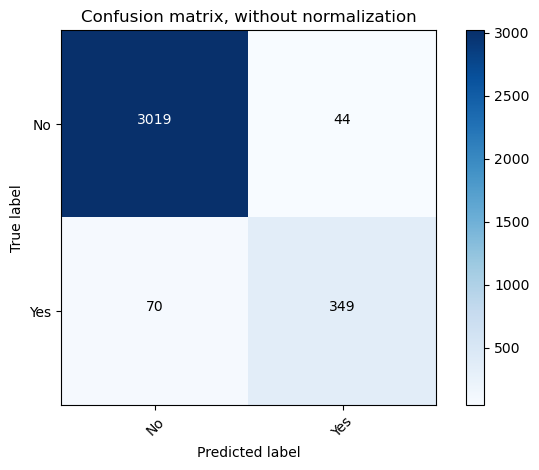

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.99      0.98      3063
         Yes       0.89      0.83      0.86       419

    accuracy                           0.97      3482
   macro avg       0.93      0.91      0.92      3482
weighted avg       0.97      0.97      0.97      3482



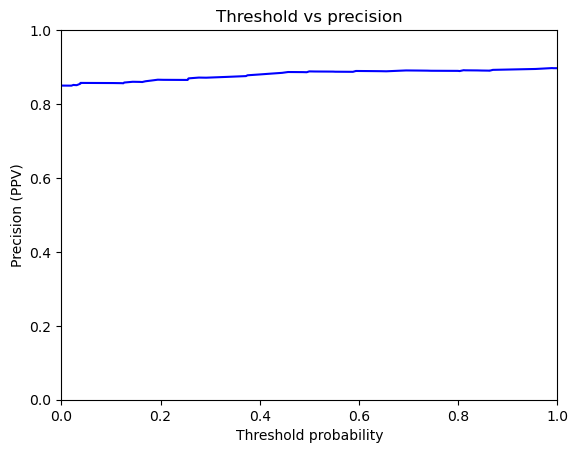

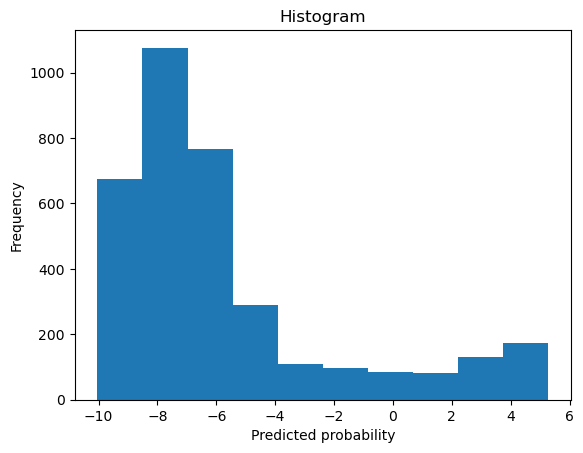

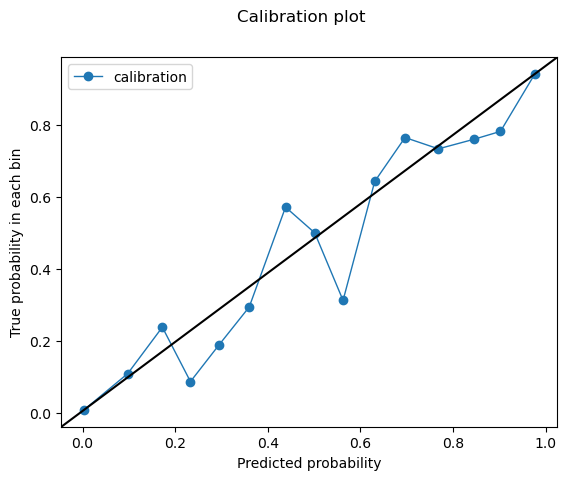

-0.5125628

In [43]:
eval_model(output_prediction_lists[6], output_true_lists[6], graph=True)

AUC 0.9664660350005178
Outcome probability: 0.1499138426191844
Average precision score: 0.88
Best F1: 0.7983453981385729


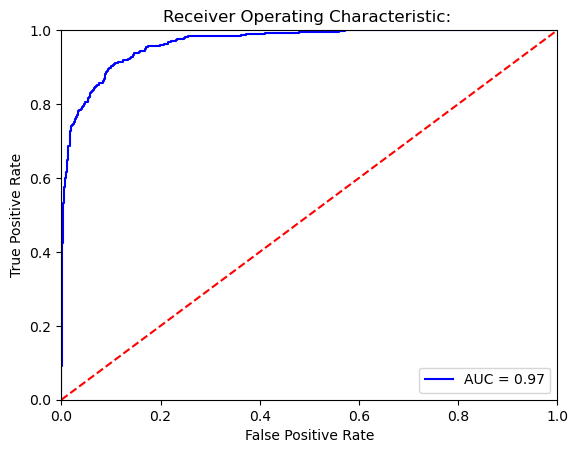

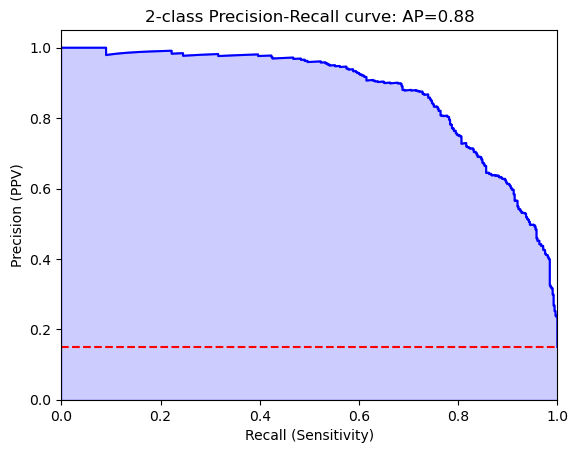

Threshold for best F1:
0.70925426
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2901   59]
 [ 136  386]]


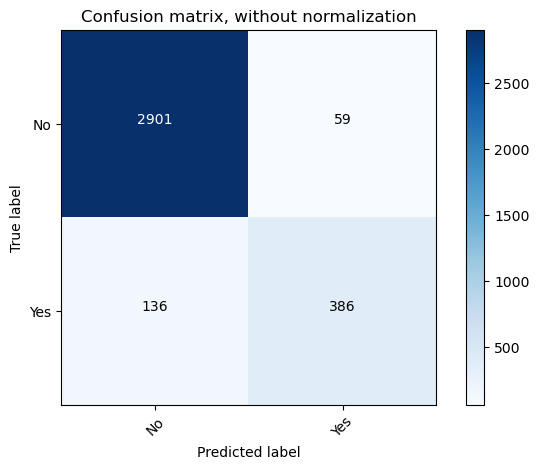

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.96      0.98      0.97      2960
         Yes       0.87      0.74      0.80       522

    accuracy                           0.94      3482
   macro avg       0.91      0.86      0.88      3482
weighted avg       0.94      0.94      0.94      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2895   65]
 [ 134  388]]


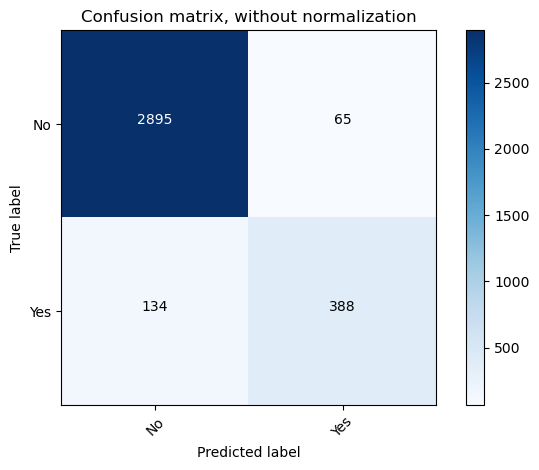

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.96      0.98      0.97      2960
         Yes       0.86      0.74      0.80       522

    accuracy                           0.94      3482
   macro avg       0.91      0.86      0.88      3482
weighted avg       0.94      0.94      0.94      3482



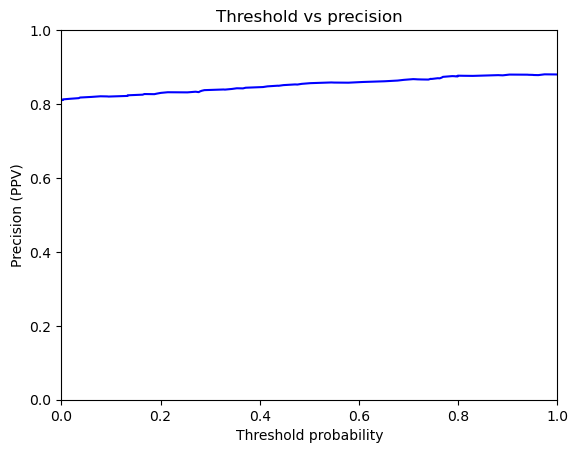

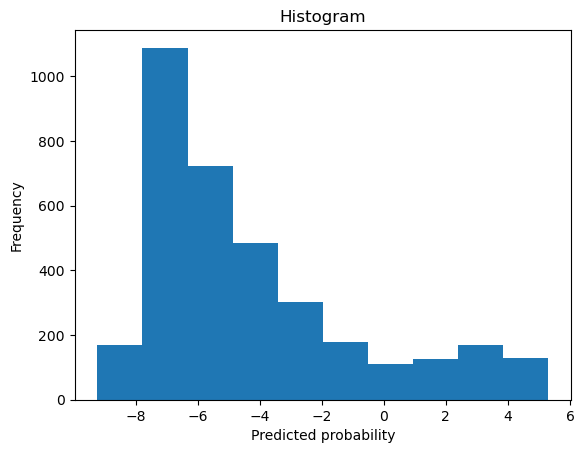

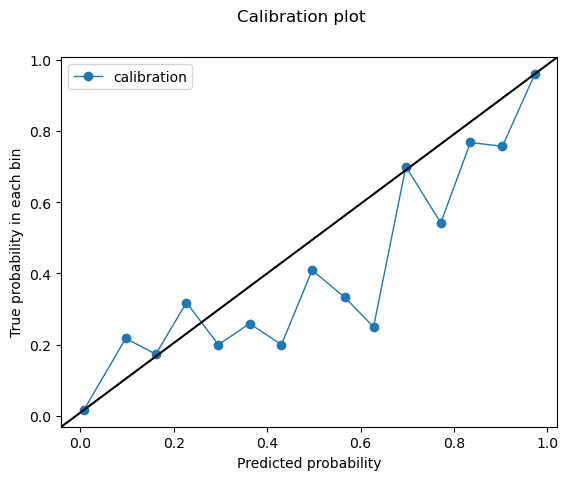

0.70925426

In [44]:
eval_model(output_prediction_lists[7], output_true_lists[7], graph=True)

AUC 0.9741968254385734
Outcome probability: 0.11315336013785181
Average precision score: 0.83
Best F1: 0.7816901408450704


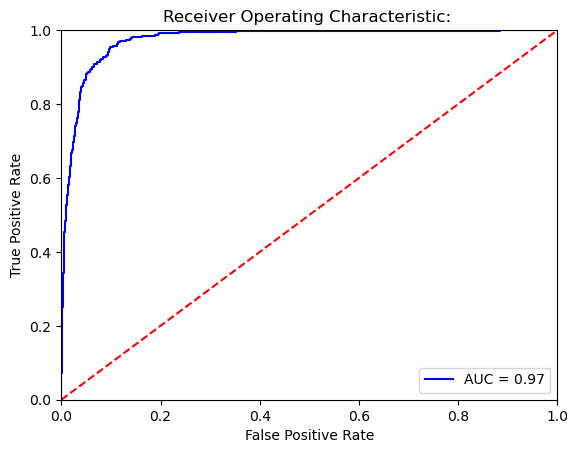

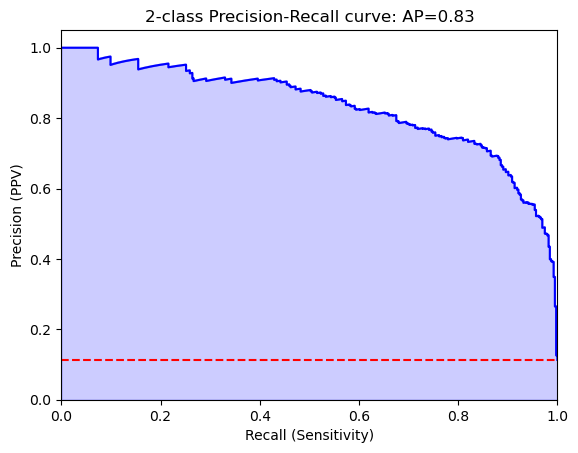

Threshold for best F1:
-0.16776733
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[2963  125]
 [  61  333]]


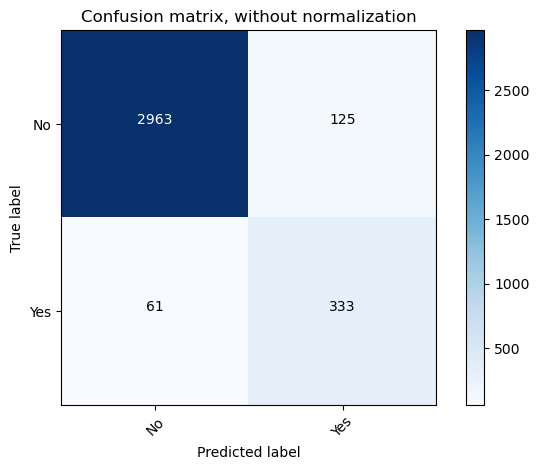

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.96      0.97      3088
         Yes       0.73      0.85      0.78       394

    accuracy                           0.95      3482
   macro avg       0.85      0.90      0.88      3482
weighted avg       0.95      0.95      0.95      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[2992   96]
 [  97  297]]


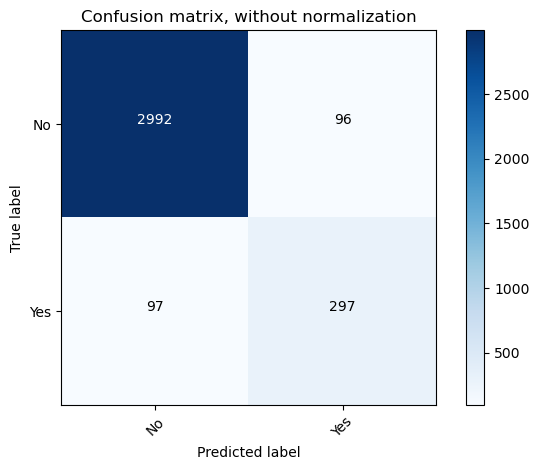

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      0.97      0.97      3088
         Yes       0.76      0.75      0.75       394

    accuracy                           0.94      3482
   macro avg       0.86      0.86      0.86      3482
weighted avg       0.94      0.94      0.94      3482



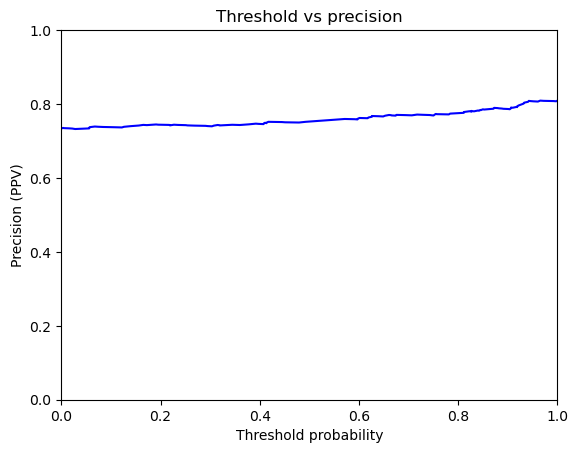

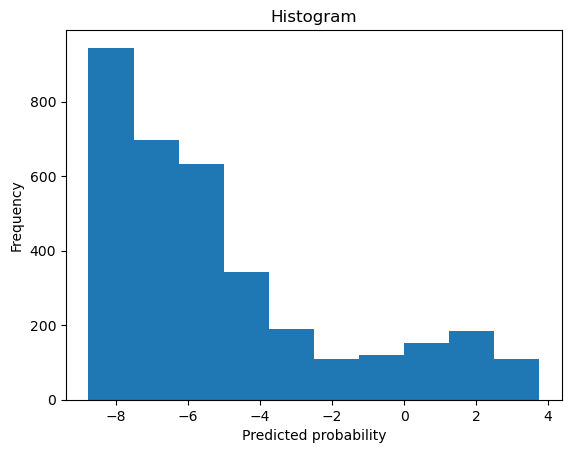

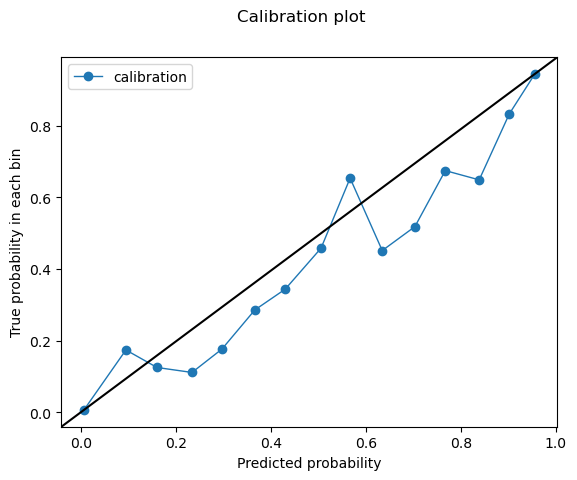

-0.16776733

In [45]:
eval_model(output_prediction_lists[8], output_true_lists[8], graph=True)

AUC 0.9868170755814518
Outcome probability: 0.02613440551407237
Average precision score: 0.79
Best F1: 0.7474747474747475


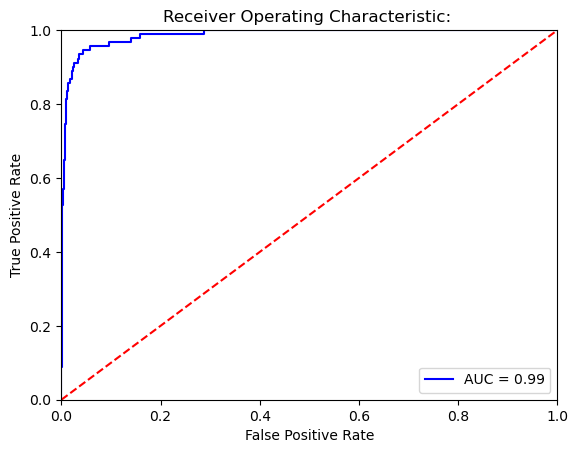

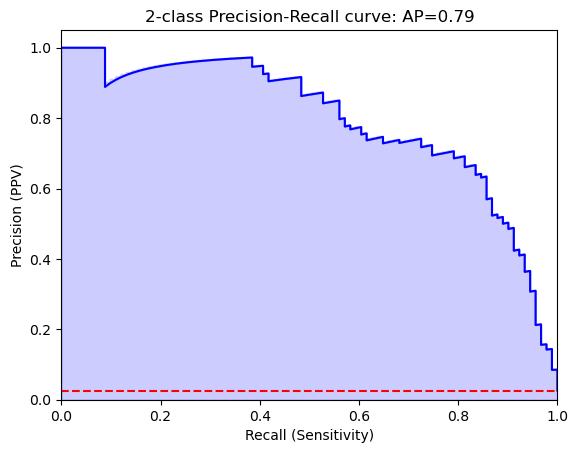

Threshold for best F1:
-0.13549922
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[3358   33]
 [  17   74]]


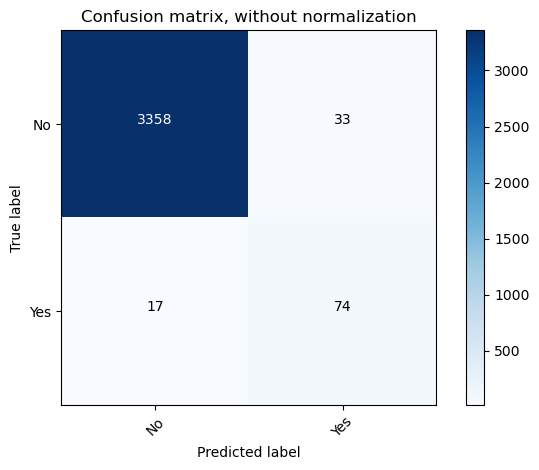

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.99      0.99      3391
         Yes       0.69      0.81      0.75        91

    accuracy                           0.99      3482
   macro avg       0.84      0.90      0.87      3482
weighted avg       0.99      0.99      0.99      3482

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[3368   23]
 [  28   63]]


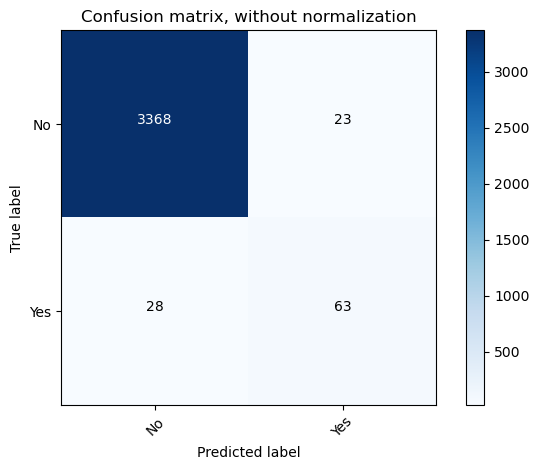

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      0.99      0.99      3391
         Yes       0.73      0.69      0.71        91

    accuracy                           0.99      3482
   macro avg       0.86      0.84      0.85      3482
weighted avg       0.98      0.99      0.99      3482



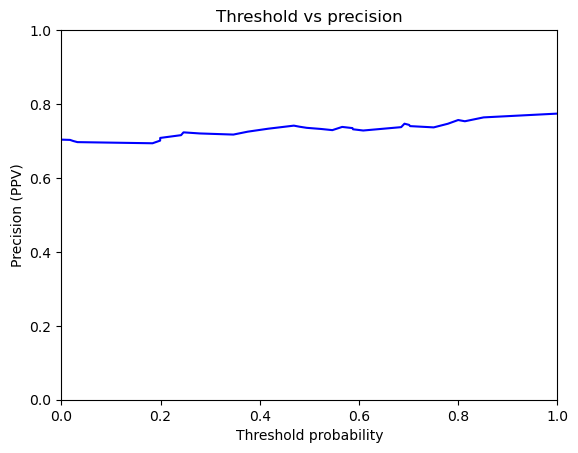

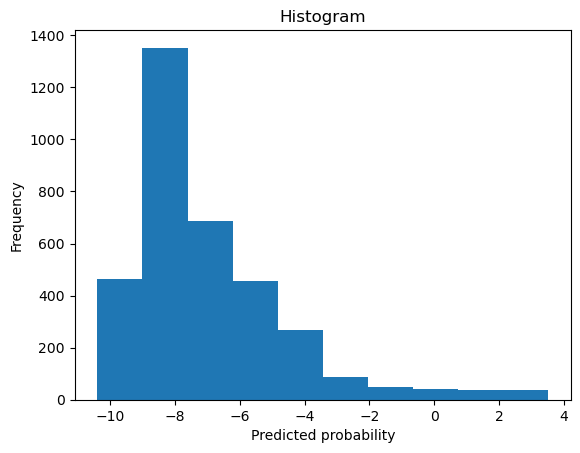

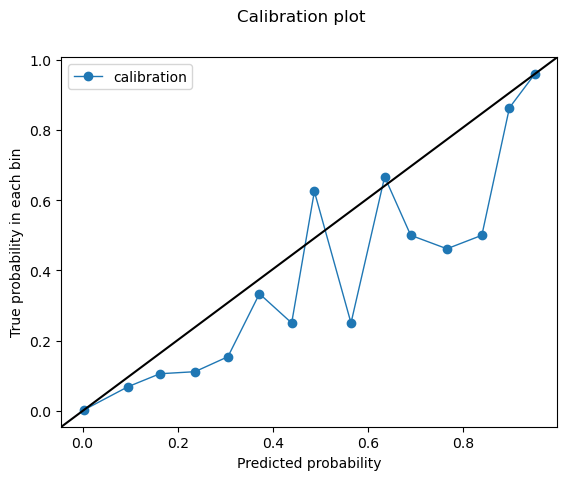

-0.13549922

In [46]:
eval_model(output_prediction_lists[9], output_true_lists[9], graph=True)

In [48]:
output_validation.to_csv('./data/prissmm_output_validation_mimic_train.csv')

In [78]:
nsclc = output_validation[output_validation.cancer_type.str.contains('crc')]

In [79]:
roc_auc_score(nsclc.any_cancer, nsclc.outcome_0_logit)

0.9615580886738685

In [80]:
roc_auc_score(nsclc.response, nsclc.outcome_1_logit)

0.9798930729893073

In [81]:
roc_auc_score(nsclc.progression, nsclc.outcome_2_logit)

0.9689416231608923

In [18]:
# write out actual test dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('dfci_mimic_imaging_bert.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_test_dataset = data.DataLoader(LabeledDataset(test), batch_size=16, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(10)]
output_prediction_lists = [[] for x in range(10)]
for batch in no_shuffle_test_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(10):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_test = test.copy()
for x in range(10):
    output_test['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



In [19]:
from sklearn.metrics import roc_auc_score


In [20]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(10)]

0.9715749410958404
0.9767829141183383
0.9541434770911559
0.9959463767513302
0.9890043290043289
0.9866940722353883
0.98626172863482
0.9746927513455769
0.9710726300995633
0.9896132574092439


[None, None, None, None, None, None, None, None, None, None]